In [ ]:

# # Segmentación binaria con Keras: detección de paneles solares 

In [14]:
## Paso 1: Importar librerías necesarias
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from PIL import Image
import os

In [52]:
class DataGenerator(Sequence):
    def __init__(self, img_dir, mask_dir=None, batch_size=8, img_size=(256, 256), shuffle=True, file_list=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.use_masks = mask_dir is not None

        if file_list is not None:
            self.img_filenames = file_list
        else:
            self.img_filenames = [
                f for f in os.listdir(img_dir)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
                and not f.lower().endswith('thumbs.db')
            ]

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.img_filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_filenames = self.img_filenames[index*self.batch_size:(index+1)*self.batch_size]
        return self.__data_generation(batch_filenames)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.img_filenames)

    def __data_generation(self, batch_filenames):
        X = np.empty((self.batch_size, *self.img_size, 3), dtype=np.float32)

        if self.use_masks:
            Y = np.empty((self.batch_size, *self.img_size, 1), dtype=np.float32)
        else:
            Y = None

        for i, fname in enumerate(batch_filenames):
            img_path = os.path.join(self.img_dir, fname)
            img = cv2.imread(img_path)
            print("RutaIMG:", img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            img = img / 255.0
            X[i,] = img.astype(np.float32)

            if self.use_masks:
                mask_path = os.path.join(self.mask_dir, fname)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, self.img_size)
                mask = (mask > 127).astype(np.float32)
                mask = np.expand_dims(mask, axis=-1)
                Y[i,] = mask

        return (X, Y) if self.use_masks else X


In [28]:
## Paso 3: Definir métrica Dice // básicamente con esto calculo la intersección para ver el rendimiento, aplanamos a vector 1D, calculamos intersección y aplico fórmula Dice.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-6) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1e-6)

In [29]:
## Paso 4: Definir modelo de segmentación simple (mini U-Net)
def simple_segmentation_model(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    x1 = Conv2D(16, (3,3), padding="same")(inputs)
    x1 = BatchNormalization()(x1)
    x1 = Activation("relu")(x1)
    p1 = MaxPooling2D((2,2))(x1)
    
    x2 = Conv2D(32, (3,3), padding="same")(p1)
    x2 = BatchNormalization()(x2)
    x2 = Activation("relu")(x2)
    p2 = MaxPooling2D((2,2))(x2)
    
    x3 = Conv2D(64, (3,3), padding="same")(p2)
    x3 = BatchNormalization()(x3)
    x3 = Activation("relu")(x3)
    
    u2 = UpSampling2D((2,2))(x3)
    u2 = Concatenate()([u2, x2])
    
    x4 = Conv2D(32, (3,3), padding="same")(u2)
    x4 = BatchNormalization()(x4)
    x4 = Activation("relu")(x4)
    
    u1 = UpSampling2D((2,2))(x4)
    u1 = Concatenate()([u1, x1])
    
    x5 = Conv2D(16, (3,3), padding="same")(u1)
    x5 = BatchNormalization()(x5)
    x5 = Activation("relu")(x5)
    
    outputs = Conv2D(1, (1,1), activation="sigmoid")(x5)
    return Model(inputs, outputs)

In [30]:
## Paso 5: Cargar datos, generar conjuntos

imgs_path = r"E:\aaLucas\L-masker\dataOK_L-masker\images"
masks_path = r"E:\aaLucas\L-masker\dataOK_L-masker\masks"

all_files = os.listdir(imgs_path)
train_val_files, test_files = train_test_split(all_files, test_size=0.02, random_state=42)
train_files, val_files = train_test_split(train_val_files, test_size=0.105, random_state=42)


batch_size = 8


train_generator = DataGenerator(imgs_path, masks_path, batch_size=8, file_list=train_files, shuffle=True)
val_generator = DataGenerator(imgs_path, masks_path, batch_size=8, file_list=val_files, shuffle=False)


In [31]:
def is_image_corrupt(filepath):
    try:
        with Image.open(filepath) as img:
            img.verify()
        return False
    except Exception:
        return True

def count_corrupt_images(folder_path):
    corrupt_count = 0
    total_files = 0

    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        if os.path.isfile(filepath):
            total_files += 1
            if is_image_corrupt(filepath):
                corrupt_count += 1
                os.remove(filepath)
                print("Eliminado: ",filepath)

    print(f"Total archivos: {total_files}")
    print(f"Imágenes corruptas: {corrupt_count}")

# Ejemplo de uso
folder_images = r"E:\aaLucas\L-masker\dataOK_L-masker\images"
folder_masks = r"E:\aaLucas\L-masker\dataOK_L-masker\masks"

print("Revisando imágenes satelitales:")
count_corrupt_images(folder_images)

print("Revisando imágenes satelitales:")
count_corrupt_images(folder_masks)


Revisando imágenes satelitales:
Total archivos: 5795
Imágenes corruptas: 0
Revisando imágenes satelitales:
Total archivos: 5795
Imágenes corruptas: 0


In [32]:
## Paso 6: Cargar, compilar modelo y entrenar

model = simple_segmentation_model()

checkpoint = ModelCheckpoint(
    "L-masker_BEST.h5", monitor='val_dice_coef',
    mode='max', save_best_only=True, verbose=1
)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', dice_coef]
)

print("model.fit")

model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[checkpoint]
)

model.fit


e:\aaLucas\L-masker\L-masker-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9149 - dice_coef: 0.8655 - loss: 0.2838
Epoch 1: val_dice_coef improved from -inf to 0.96846, saving model to L-masker_BEST.h5


635/635 ━━━━━━━━━━━━━━━━━━━━ 111s 168ms/step - accuracy: 0.9150 - dice_coef: 0.8656 - loss: 0.2836 - val_accuracy: 0.9725 - val_dice_coef: 0.9685 - val_loss: 0.0831
Epoch 2/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9754 - dice_coef: 0.9726 - loss: 0.0737
Epoch 2: val_dice_coef improved from 0.96846 to 0.97836, saving model to L-masker_BEST.h5


635/635 ━━━━━━━━━━━━━━━━━━━━ 105s 166ms/step - accuracy: 0.9754 - dice_coef: 0.9726 - loss: 0.0737 - val_accuracy: 0.9799 - val_dice_coef: 0.9784 - val_loss: 0.0623
Epoch 3/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9797 - dice_coef: 0.9797 - loss: 0.0578
Epoch 3: val_dice_coef improved from 0.97836 to 0.98233, saving model to L-masker_BEST.h5


635/635 ━━━━━━━━━━━━━━━━━━━━ 107s 168ms/step - accuracy: 0.9797 - dice_coef: 0.9797 - loss: 0.0577 - val_accuracy: 0.9756 - val_dice_coef: 0.9823 - val_loss: 0.0725
Epoch 4/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9814 - dice_coef: 0.9827 - loss: 0.0520
Epoch 4: val_dice_coef improved from 0.98233 to 0.98656, saving model to L-masker_BEST.h5


635/635 ━━━━━━━━━━━━━━━━━━━━ 106s 167ms/step - accuracy: 0.9814 - dice_coef: 0.9827 - loss: 0.0520 - val_accuracy: 0.9835 - val_dice_coef: 0.9866 - val_loss: 0.0448
Epoch 5/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9853 - dice_coef: 0.9866 - loss: 0.0405
Epoch 5: val_dice_coef did not improve from 0.98656
635/635 ━━━━━━━━━━━━━━━━━━━━ 105s 166ms/step - accuracy: 0.9853 - dice_coef: 0.9866 - loss: 0.0405 - val_accuracy: 0.9806 - val_dice_coef: 0.9847 - val_loss: 0.0553
Epoch 6/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9848 - dice_coef: 0.9862 - loss: 0.0411
Epoch 6: val_dice_coef did not improve from 0.98656
635/635 ━━━━━━━━━━━━━━━━━━━━ 105s 165ms/step - accuracy: 0.9848 - dice_coef: 0.9862 - loss: 0.0411 - val_accuracy: 0.9828 - val_dice_coef: 0.9856 - val_loss: 0.0468
Epoch 7/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9850 - dice_coef: 0.9866 - loss: 0.0404
Epoch 7: val_dice_coef did not improve from 0.98656
635/635 ━━━━━━━━━━━━━━

635/635 ━━━━━━━━━━━━━━━━━━━━ 106s 167ms/step - accuracy: 0.9868 - dice_coef: 0.9882 - loss: 0.0354 - val_accuracy: 0.9844 - val_dice_coef: 0.9877 - val_loss: 0.0418
Epoch 10/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9872 - dice_coef: 0.9886 - loss: 0.0336
Epoch 10: val_dice_coef did not improve from 0.98770
635/635 ━━━━━━━━━━━━━━━━━━━━ 107s 168ms/step - accuracy: 0.9871 - dice_coef: 0.9886 - loss: 0.0336 - val_accuracy: 0.9805 - val_dice_coef: 0.9824 - val_loss: 0.0519
Epoch 11/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9878 - dice_coef: 0.9889 - loss: 0.0327
Epoch 11: val_dice_coef did not improve from 0.98770
635/635 ━━━━━━━━━━━━━━━━━━━━ 105s 166ms/step - accuracy: 0.9878 - dice_coef: 0.9889 - loss: 0.0327 - val_accuracy: 0.9736 - val_dice_coef: 0.9825 - val_loss: 0.0976
Epoch 12/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9876 - dice_coef: 0.9891 - loss: 0.0330
Epoch 12: val_dice_coef improved from 0.98770 to 0.98970, saving mode

635/635 ━━━━━━━━━━━━━━━━━━━━ 105s 166ms/step - accuracy: 0.9876 - dice_coef: 0.9891 - loss: 0.0330 - val_accuracy: 0.9870 - val_dice_coef: 0.9897 - val_loss: 0.0355
Epoch 13/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9879 - dice_coef: 0.9895 - loss: 0.0324
Epoch 13: val_dice_coef did not improve from 0.98970
635/635 ━━━━━━━━━━━━━━━━━━━━ 105s 165ms/step - accuracy: 0.9879 - dice_coef: 0.9895 - loss: 0.0324 - val_accuracy: 0.9867 - val_dice_coef: 0.9878 - val_loss: 0.0366
Epoch 14/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9886 - dice_coef: 0.9901 - loss: 0.0306
Epoch 14: val_dice_coef improved from 0.98970 to 0.99018, saving model to L-masker_BEST.h5


635/635 ━━━━━━━━━━━━━━━━━━━━ 105s 165ms/step - accuracy: 0.9886 - dice_coef: 0.9901 - loss: 0.0306 - val_accuracy: 0.9876 - val_dice_coef: 0.9902 - val_loss: 0.0328
Epoch 15/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9884 - dice_coef: 0.9899 - loss: 0.0305
Epoch 15: val_dice_coef did not improve from 0.99018
635/635 ━━━━━━━━━━━━━━━━━━━━ 106s 167ms/step - accuracy: 0.9884 - dice_coef: 0.9899 - loss: 0.0305 - val_accuracy: 0.9856 - val_dice_coef: 0.9882 - val_loss: 0.0387
Epoch 16/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9889 - dice_coef: 0.9902 - loss: 0.0291
Epoch 16: val_dice_coef did not improve from 0.99018
635/635 ━━━━━━━━━━━━━━━━━━━━ 106s 166ms/step - accuracy: 0.9889 - dice_coef: 0.9902 - loss: 0.0291 - val_accuracy: 0.9868 - val_dice_coef: 0.9890 - val_loss: 0.0344
Epoch 17/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9885 - dice_coef: 0.9899 - loss: 0.0304
Epoch 17: val_dice_coef did not improve from 0.99018
635/635 ━━━━━━━━

635/635 ━━━━━━━━━━━━━━━━━━━━ 105s 166ms/step - accuracy: 0.9886 - dice_coef: 0.9901 - loss: 0.0302 - val_accuracy: 0.9881 - val_dice_coef: 0.9905 - val_loss: 0.0323
Epoch 21/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9889 - dice_coef: 0.9905 - loss: 0.0304
Epoch 21: val_dice_coef did not improve from 0.99054
635/635 ━━━━━━━━━━━━━━━━━━━━ 106s 167ms/step - accuracy: 0.9889 - dice_coef: 0.9905 - loss: 0.0304 - val_accuracy: 0.9866 - val_dice_coef: 0.9879 - val_loss: 0.0361
Epoch 22/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9899 - dice_coef: 0.9913 - loss: 0.0270
Epoch 22: val_dice_coef did not improve from 0.99054
635/635 ━━━━━━━━━━━━━━━━━━━━ 105s 166ms/step - accuracy: 0.9899 - dice_coef: 0.9913 - loss: 0.0270 - val_accuracy: 0.9883 - val_dice_coef: 0.9901 - val_loss: 0.0322
Epoch 23/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9901 - dice_coef: 0.9915 - loss: 0.0256
Epoch 23: val_dice_coef improved from 0.99054 to 0.99106, saving mode

635/635 ━━━━━━━━━━━━━━━━━━━━ 105s 165ms/step - accuracy: 0.9901 - dice_coef: 0.9915 - loss: 0.0256 - val_accuracy: 0.9890 - val_dice_coef: 0.9911 - val_loss: 0.0297
Epoch 24/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9897 - dice_coef: 0.9911 - loss: 0.0271
Epoch 24: val_dice_coef did not improve from 0.99106
635/635 ━━━━━━━━━━━━━━━━━━━━ 105s 165ms/step - accuracy: 0.9897 - dice_coef: 0.9911 - loss: 0.0271 - val_accuracy: 0.9884 - val_dice_coef: 0.9908 - val_loss: 0.0317
Epoch 25/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9897 - dice_coef: 0.9910 - loss: 0.0273
Epoch 25: val_dice_coef did not improve from 0.99106
635/635 ━━━━━━━━━━━━━━━━━━━━ 105s 165ms/step - accuracy: 0.9897 - dice_coef: 0.9910 - loss: 0.0273 - val_accuracy: 0.9888 - val_dice_coef: 0.9908 - val_loss: 0.0297
Epoch 26/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9899 - dice_coef: 0.9913 - loss: 0.0262
Epoch 26: val_dice_coef improved from 0.99106 to 0.99163, saving mode

635/635 ━━━━━━━━━━━━━━━━━━━━ 106s 166ms/step - accuracy: 0.9899 - dice_coef: 0.9913 - loss: 0.0262 - val_accuracy: 0.9896 - val_dice_coef: 0.9916 - val_loss: 0.0279
Epoch 27/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9906 - dice_coef: 0.9918 - loss: 0.0246
Epoch 27: val_dice_coef did not improve from 0.99163
635/635 ━━━━━━━━━━━━━━━━━━━━ 107s 168ms/step - accuracy: 0.9906 - dice_coef: 0.9918 - loss: 0.0246 - val_accuracy: 0.9822 - val_dice_coef: 0.9875 - val_loss: 0.0577
Epoch 28/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9900 - dice_coef: 0.9912 - loss: 0.0268
Epoch 28: val_dice_coef improved from 0.99163 to 0.99200, saving model to L-masker_BEST.h5


635/635 ━━━━━━━━━━━━━━━━━━━━ 105s 166ms/step - accuracy: 0.9900 - dice_coef: 0.9912 - loss: 0.0268 - val_accuracy: 0.9899 - val_dice_coef: 0.9920 - val_loss: 0.0266
Epoch 29/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9903 - dice_coef: 0.9916 - loss: 0.0256
Epoch 29: val_dice_coef did not improve from 0.99200
635/635 ━━━━━━━━━━━━━━━━━━━━ 106s 166ms/step - accuracy: 0.9903 - dice_coef: 0.9916 - loss: 0.0256 - val_accuracy: 0.9891 - val_dice_coef: 0.9910 - val_loss: 0.0284
Epoch 30/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9905 - dice_coef: 0.9917 - loss: 0.0254
Epoch 30: val_dice_coef did not improve from 0.99200
635/635 ━━━━━━━━━━━━━━━━━━━━ 104s 163ms/step - accuracy: 0.9905 - dice_coef: 0.9917 - loss: 0.0254 - val_accuracy: 0.9896 - val_dice_coef: 0.9912 - val_loss: 0.0275
Epoch 31/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9903 - dice_coef: 0.9916 - loss: 0.0257
Epoch 31: val_dice_coef did not improve from 0.99200
635/635 ━━━━━━━━

635/635 ━━━━━━━━━━━━━━━━━━━━ 105s 165ms/step - accuracy: 0.9910 - dice_coef: 0.9921 - loss: 0.0238 - val_accuracy: 0.9904 - val_dice_coef: 0.9924 - val_loss: 0.0254
Epoch 46/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9912 - dice_coef: 0.9924 - loss: 0.0230
Epoch 46: val_dice_coef improved from 0.99244 to 0.99246, saving model to L-masker_BEST.h5


635/635 ━━━━━━━━━━━━━━━━━━━━ 104s 163ms/step - accuracy: 0.9912 - dice_coef: 0.9924 - loss: 0.0230 - val_accuracy: 0.9903 - val_dice_coef: 0.9925 - val_loss: 0.0268
Epoch 47/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9912 - dice_coef: 0.9925 - loss: 0.0233
Epoch 47: val_dice_coef did not improve from 0.99246
635/635 ━━━━━━━━━━━━━━━━━━━━ 104s 164ms/step - accuracy: 0.9912 - dice_coef: 0.9925 - loss: 0.0233 - val_accuracy: 0.9904 - val_dice_coef: 0.9924 - val_loss: 0.0275
Epoch 48/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9913 - dice_coef: 0.9925 - loss: 0.0229
Epoch 48: val_dice_coef did not improve from 0.99246
635/635 ━━━━━━━━━━━━━━━━━━━━ 104s 163ms/step - accuracy: 0.9913 - dice_coef: 0.9925 - loss: 0.0229 - val_accuracy: 0.9884 - val_dice_coef: 0.9910 - val_loss: 0.0338
Epoch 49/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9913 - dice_coef: 0.9924 - loss: 0.0225
Epoch 49: val_dice_coef improved from 0.99246 to 0.99277, saving mode

635/635 ━━━━━━━━━━━━━━━━━━━━ 104s 164ms/step - accuracy: 0.9913 - dice_coef: 0.9924 - loss: 0.0225 - val_accuracy: 0.9913 - val_dice_coef: 0.9928 - val_loss: 0.0232
Epoch 50/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9915 - dice_coef: 0.9926 - loss: 0.0224
Epoch 50: val_dice_coef did not improve from 0.99277
635/635 ━━━━━━━━━━━━━━━━━━━━ 105s 165ms/step - accuracy: 0.9915 - dice_coef: 0.9926 - loss: 0.0224 - val_accuracy: 0.9910 - val_dice_coef: 0.9924 - val_loss: 0.0240
Epoch 51/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9913 - dice_coef: 0.9925 - loss: 0.0225
Epoch 51: val_dice_coef did not improve from 0.99277
635/635 ━━━━━━━━━━━━━━━━━━━━ 104s 163ms/step - accuracy: 0.9913 - dice_coef: 0.9925 - loss: 0.0225 - val_accuracy: 0.9868 - val_dice_coef: 0.9886 - val_loss: 0.0373
Epoch 52/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9916 - dice_coef: 0.9928 - loss: 0.0217
Epoch 52: val_dice_coef did not improve from 0.99277
635/635 ━━━━━━━━

635/635 ━━━━━━━━━━━━━━━━━━━━ 105s 165ms/step - accuracy: 0.9917 - dice_coef: 0.9928 - loss: 0.0218 - val_accuracy: 0.9907 - val_dice_coef: 0.9929 - val_loss: 0.0254
Epoch 57/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9919 - dice_coef: 0.9930 - loss: 0.0211
Epoch 57: val_dice_coef did not improve from 0.99286
635/635 ━━━━━━━━━━━━━━━━━━━━ 105s 165ms/step - accuracy: 0.9919 - dice_coef: 0.9930 - loss: 0.0211 - val_accuracy: 0.9876 - val_dice_coef: 0.9798 - val_loss: 0.0528
Epoch 58/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9913 - dice_coef: 0.9924 - loss: 0.0231
Epoch 58: val_dice_coef did not improve from 0.99286
635/635 ━━━━━━━━━━━━━━━━━━━━ 104s 163ms/step - accuracy: 0.9913 - dice_coef: 0.9924 - loss: 0.0231 - val_accuracy: 0.9904 - val_dice_coef: 0.9922 - val_loss: 0.0261
Epoch 59/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9913 - dice_coef: 0.9924 - loss: 0.0234
Epoch 59: val_dice_coef did not improve from 0.99286
635/635 ━━━━━━━━

635/635 ━━━━━━━━━━━━━━━━━━━━ 106s 167ms/step - accuracy: 0.9911 - dice_coef: 0.9923 - loss: 0.0230 - val_accuracy: 0.9913 - val_dice_coef: 0.9930 - val_loss: 0.0230
Epoch 62/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9918 - dice_coef: 0.9929 - loss: 0.0217
Epoch 62: val_dice_coef did not improve from 0.99296
635/635 ━━━━━━━━━━━━━━━━━━━━ 105s 166ms/step - accuracy: 0.9918 - dice_coef: 0.9929 - loss: 0.0217 - val_accuracy: 0.9824 - val_dice_coef: 0.9867 - val_loss: 0.0513
Epoch 63/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9915 - dice_coef: 0.9927 - loss: 0.0222
Epoch 63: val_dice_coef did not improve from 0.99296
635/635 ━━━━━━━━━━━━━━━━━━━━ 104s 163ms/step - accuracy: 0.9915 - dice_coef: 0.9927 - loss: 0.0222 - val_accuracy: 0.9907 - val_dice_coef: 0.9925 - val_loss: 0.0257
Epoch 64/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9915 - dice_coef: 0.9927 - loss: 0.0231
Epoch 64: val_dice_coef did not improve from 0.99296
635/635 ━━━━━━━━

635/635 ━━━━━━━━━━━━━━━━━━━━ 104s 164ms/step - accuracy: 0.9916 - dice_coef: 0.9927 - loss: 0.0225 - val_accuracy: 0.9915 - val_dice_coef: 0.9930 - val_loss: 0.0225
Epoch 67/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9920 - dice_coef: 0.9931 - loss: 0.0208
Epoch 67: val_dice_coef improved from 0.99298 to 0.99307, saving model to L-masker_BEST.h5


635/635 ━━━━━━━━━━━━━━━━━━━━ 105s 165ms/step - accuracy: 0.9920 - dice_coef: 0.9931 - loss: 0.0208 - val_accuracy: 0.9914 - val_dice_coef: 0.9931 - val_loss: 0.0230
Epoch 68/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9917 - dice_coef: 0.9928 - loss: 0.0214
Epoch 68: val_dice_coef did not improve from 0.99307
635/635 ━━━━━━━━━━━━━━━━━━━━ 105s 165ms/step - accuracy: 0.9917 - dice_coef: 0.9928 - loss: 0.0214 - val_accuracy: 0.9896 - val_dice_coef: 0.9918 - val_loss: 0.0308
Epoch 69/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9916 - dice_coef: 0.9928 - loss: 0.0224
Epoch 69: val_dice_coef did not improve from 0.99307
635/635 ━━━━━━━━━━━━━━━━━━━━ 104s 164ms/step - accuracy: 0.9916 - dice_coef: 0.9928 - loss: 0.0224 - val_accuracy: 0.9895 - val_dice_coef: 0.9915 - val_loss: 0.0289
Epoch 70/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9922 - dice_coef: 0.9933 - loss: 0.0204
Epoch 70: val_dice_coef did not improve from 0.99307
635/635 ━━━━━━━━

635/635 ━━━━━━━━━━━━━━━━━━━━ 105s 165ms/step - accuracy: 0.9921 - dice_coef: 0.9931 - loss: 0.0211 - val_accuracy: 0.9916 - val_dice_coef: 0.9933 - val_loss: 0.0224
Epoch 86/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9921 - dice_coef: 0.9932 - loss: 0.0215
Epoch 86: val_dice_coef did not improve from 0.99328
635/635 ━━━━━━━━━━━━━━━━━━━━ 104s 164ms/step - accuracy: 0.9921 - dice_coef: 0.9932 - loss: 0.0215 - val_accuracy: 0.9918 - val_dice_coef: 0.9932 - val_loss: 0.0220
Epoch 87/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9923 - dice_coef: 0.9933 - loss: 0.0202
Epoch 87: val_dice_coef did not improve from 0.99328
635/635 ━━━━━━━━━━━━━━━━━━━━ 104s 164ms/step - accuracy: 0.9923 - dice_coef: 0.9933 - loss: 0.0202 - val_accuracy: 0.9907 - val_dice_coef: 0.9925 - val_loss: 0.0247
Epoch 88/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9917 - dice_coef: 0.9928 - loss: 0.0220
Epoch 88: val_dice_coef did not improve from 0.99328
635/635 ━━━━━━━━

635/635 ━━━━━━━━━━━━━━━━━━━━ 105s 165ms/step - accuracy: 0.9925 - dice_coef: 0.9934 - loss: 0.0197 - val_accuracy: 0.9917 - val_dice_coef: 0.9934 - val_loss: 0.0219
Epoch 98/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9927 - dice_coef: 0.9937 - loss: 0.0188
Epoch 98: val_dice_coef did not improve from 0.99337
635/635 ━━━━━━━━━━━━━━━━━━━━ 105s 165ms/step - accuracy: 0.9927 - dice_coef: 0.9937 - loss: 0.0188 - val_accuracy: 0.9915 - val_dice_coef: 0.9924 - val_loss: 0.0229
Epoch 99/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9926 - dice_coef: 0.9936 - loss: 0.0191
Epoch 99: val_dice_coef did not improve from 0.99337
635/635 ━━━━━━━━━━━━━━━━━━━━ 105s 165ms/step - accuracy: 0.9926 - dice_coef: 0.9936 - loss: 0.0191 - val_accuracy: 0.9876 - val_dice_coef: 0.9908 - val_loss: 0.0446
Epoch 100/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9922 - dice_coef: 0.9932 - loss: 0.0207
Epoch 100: val_dice_coef did not improve from 0.99337
635/635 ━━━━━━

In [59]:
test_generator = DataGenerator(
    imgs_path,
    masks_path,
    batch_size=8,
    file_list=test_files,
    shuffle=False
)

results = model.evaluate(test_generator)
print(f"Pérdida y métricas en test: {results}")

preds = model.predict(test_generator)

import matplotlib.pyplot as plt

# Tomar un batch del generador
X_batch, Y_batch = test_generator[0]         # imágenes y máscaras verdaderas
preds_batch = model.predict(X_batch)         # máscaras predichas

for i in range(len(X_batch)):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.title("Imagen")
    plt.imshow(X_batch[i])
    
    plt.subplot(1, 3, 2)
    plt.title("Máscara real")
    plt.imshow(Y_batch[i].squeeze(), cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title("Predicción")
    plt.imshow(preds_batch[i].squeeze(), cmap='gray')
    
    plt.show()



RutaIMG: E:\aaLucas\L-masker\dataOK_L-masker\images\E


e:\aaLucas\L-masker\L-masker-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


3
RutaIMG: E:\aaLucas\L-masker\Julian\julian2.png
RutaIMG: E:\aaLucas\L-masker\Julian\prueba_enmascarada.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


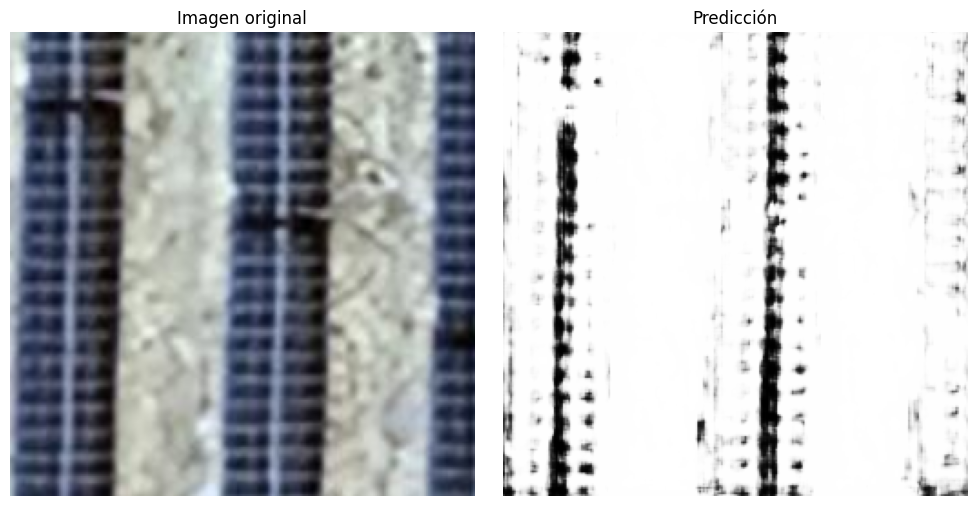

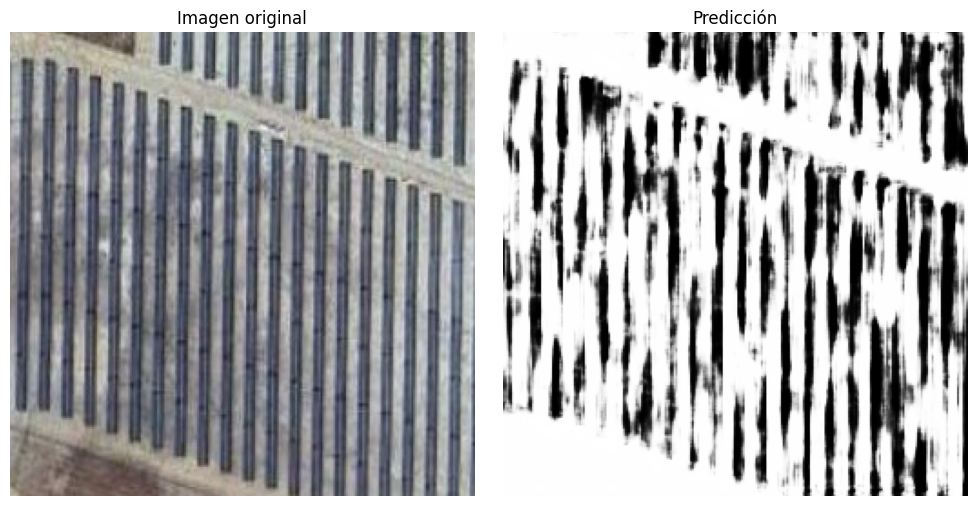

Resultados guardados en: E:\aaLucas\L-masker\Julian


In [ ]:
# Lista de archivos que quieres usar en el generador
img_dir = r"E:\aaLucas\L-masker\Julian"
output_dir = r"E:\aaLucas\L-masker\Julian"

test_files = [
    f for f in os.listdir(img_dir)
    if f.lower().endswith(('.png', '.jpg', '.jpeg')) and not f.lower().endswith('thumbs.db')
]

print(len(test_files))

# Instanciar el generador solo con imágenes
test_custom = DataGenerator(
    img_dir=img_dir,
    #mask_dir=
    batch_size=3,
    file_list=test_files,
    shuffle=False
)

for batch_idx in range(len(test_custom)):
    X_batch = test_custom[batch_idx]  # Solo imágenes
    preds_batch = model.predict(X_batch)

    for i in range(len(X_batch)):
        img = (X_batch[i] * 255).astype(np.uint8)
        pred_mask = preds_batch[i].squeeze()

        # Escalar predicción a 0–255 si está normalizada
        if pred_mask.max() <= 1.0:
            pred_mask = (pred_mask * 255).astype(np.uint8)
        else:
            pred_mask = pred_mask.astype(np.uint8)

        # Crear figura con imagen original y predicción
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(img)
        axes[0].set_title("Imagen original")
        axes[0].axis('off')

        axes[1].imshow(pred_mask, cmap='gray')
        axes[1].set_title("Predicción")
        axes[1].axis('off')

        plt.tight_layout()

        sample_idx = batch_idx * test_custom.batch_size + i
        output_path = os.path.join(output_dir, f"resultado_JULIAN_{sample_idx}.png")
        plt.savefig(output_path)
        plt.show()
        plt.close()
        
print(f"Resultados guardados en: {output_dir}")

